<a href="https://colab.research.google.com/github/alexchilton/CAS_Project/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import libraries

In [1]:
%pip install tqdn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import LearningRateScheduler

# 2. Paths and constants

In [3]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
# For Colab only_move to function file directory, load and go back to content /drive
%cd /content/drive/MyDrive/CAS_AML/function_files
import functions_m1_m2
%cd /content/drive

/content/drive/MyDrive/CAS_AML/function_files
/content/drive


In [5]:
DIR_TRAIN = '/content/drive/MyDrive/CAS_AML/datasets/fruits_clean/train'
DIR_TEST = '/content/drive/MyDrive/CAS_AML/datasets/fruits_clean/test'
DIR_VALIDATION = '/content/drive/MyDrive/CAS_AML/datasets/fruits_clean/validation'
OUTPUT_DIR = '/content/drive/MyDrive/CAS_AML/outputs'


MODEL_LOCATION = '/content/drive/MyDrive/CAS_AML/models'

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 3. Dataset preparation

In [19]:
train_dir = DIR_TRAIN
validation_dir = DIR_VALIDATION

BATCH_SIZE = 32
IMG_SIZE = (299, 299)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2362 files belonging to 33 classes.


In [20]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 302 files belonging to 33 classes.


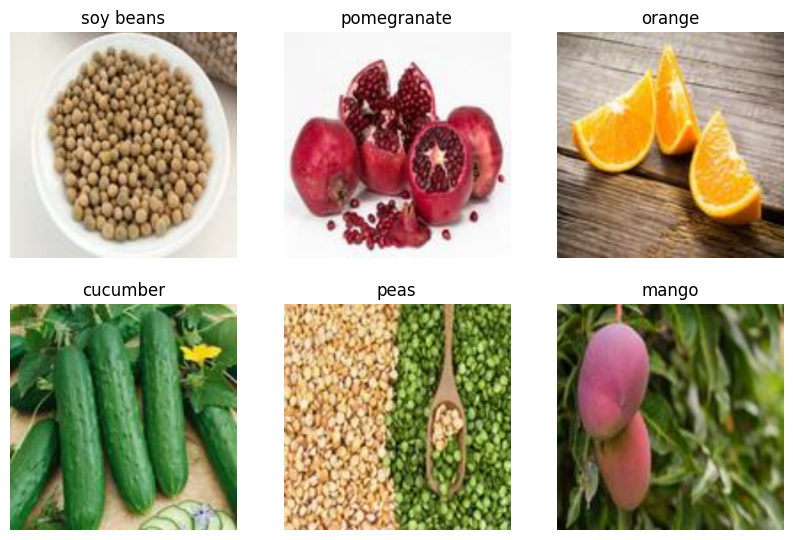

In [21]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [22]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [23]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 8
Number of test batches: 2


In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## 3.1 Data augmentation for better generalization

In [25]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


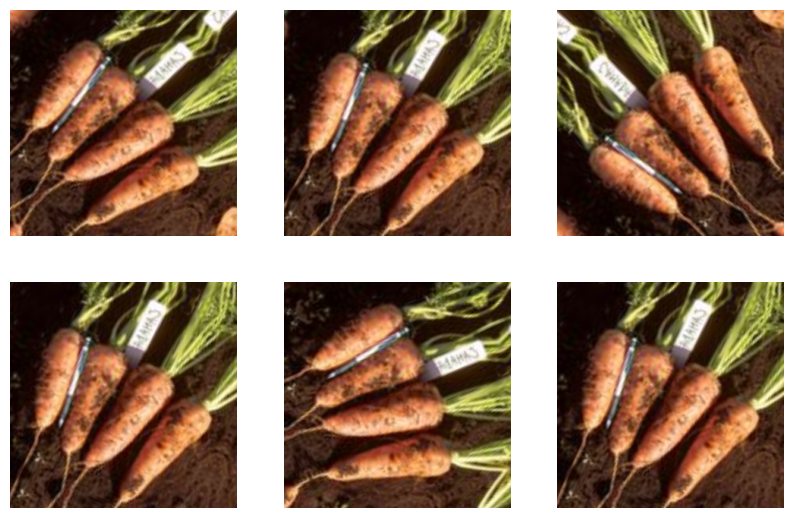

In [26]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


# 4. Transfer learning

## 4.1 ResNet50

https://keras.io/api/applications/resnet/

In [15]:
from tensorflow.keras.applications import resnet50

### 4.1.1 Data preprocessing

In [16]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

### 4.1.2 Base model

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


### 4.1.3 Feature extraction

When unfreezing a model that contains BatchNormalization layers in order to do fine-tuning, the BatchNormalization layers should be kept in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [19]:
base_model.trainable = False

In [20]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### 4.1.4 Top layer: classifier

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [22]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 33)


In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 33)             │         67,617 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,655,329 (90.24 MB)

 Trainable params: 67,617 (264.13 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 4.1.5 Model and parameter summary

In [25]:
len(model.trainable_variables)

2

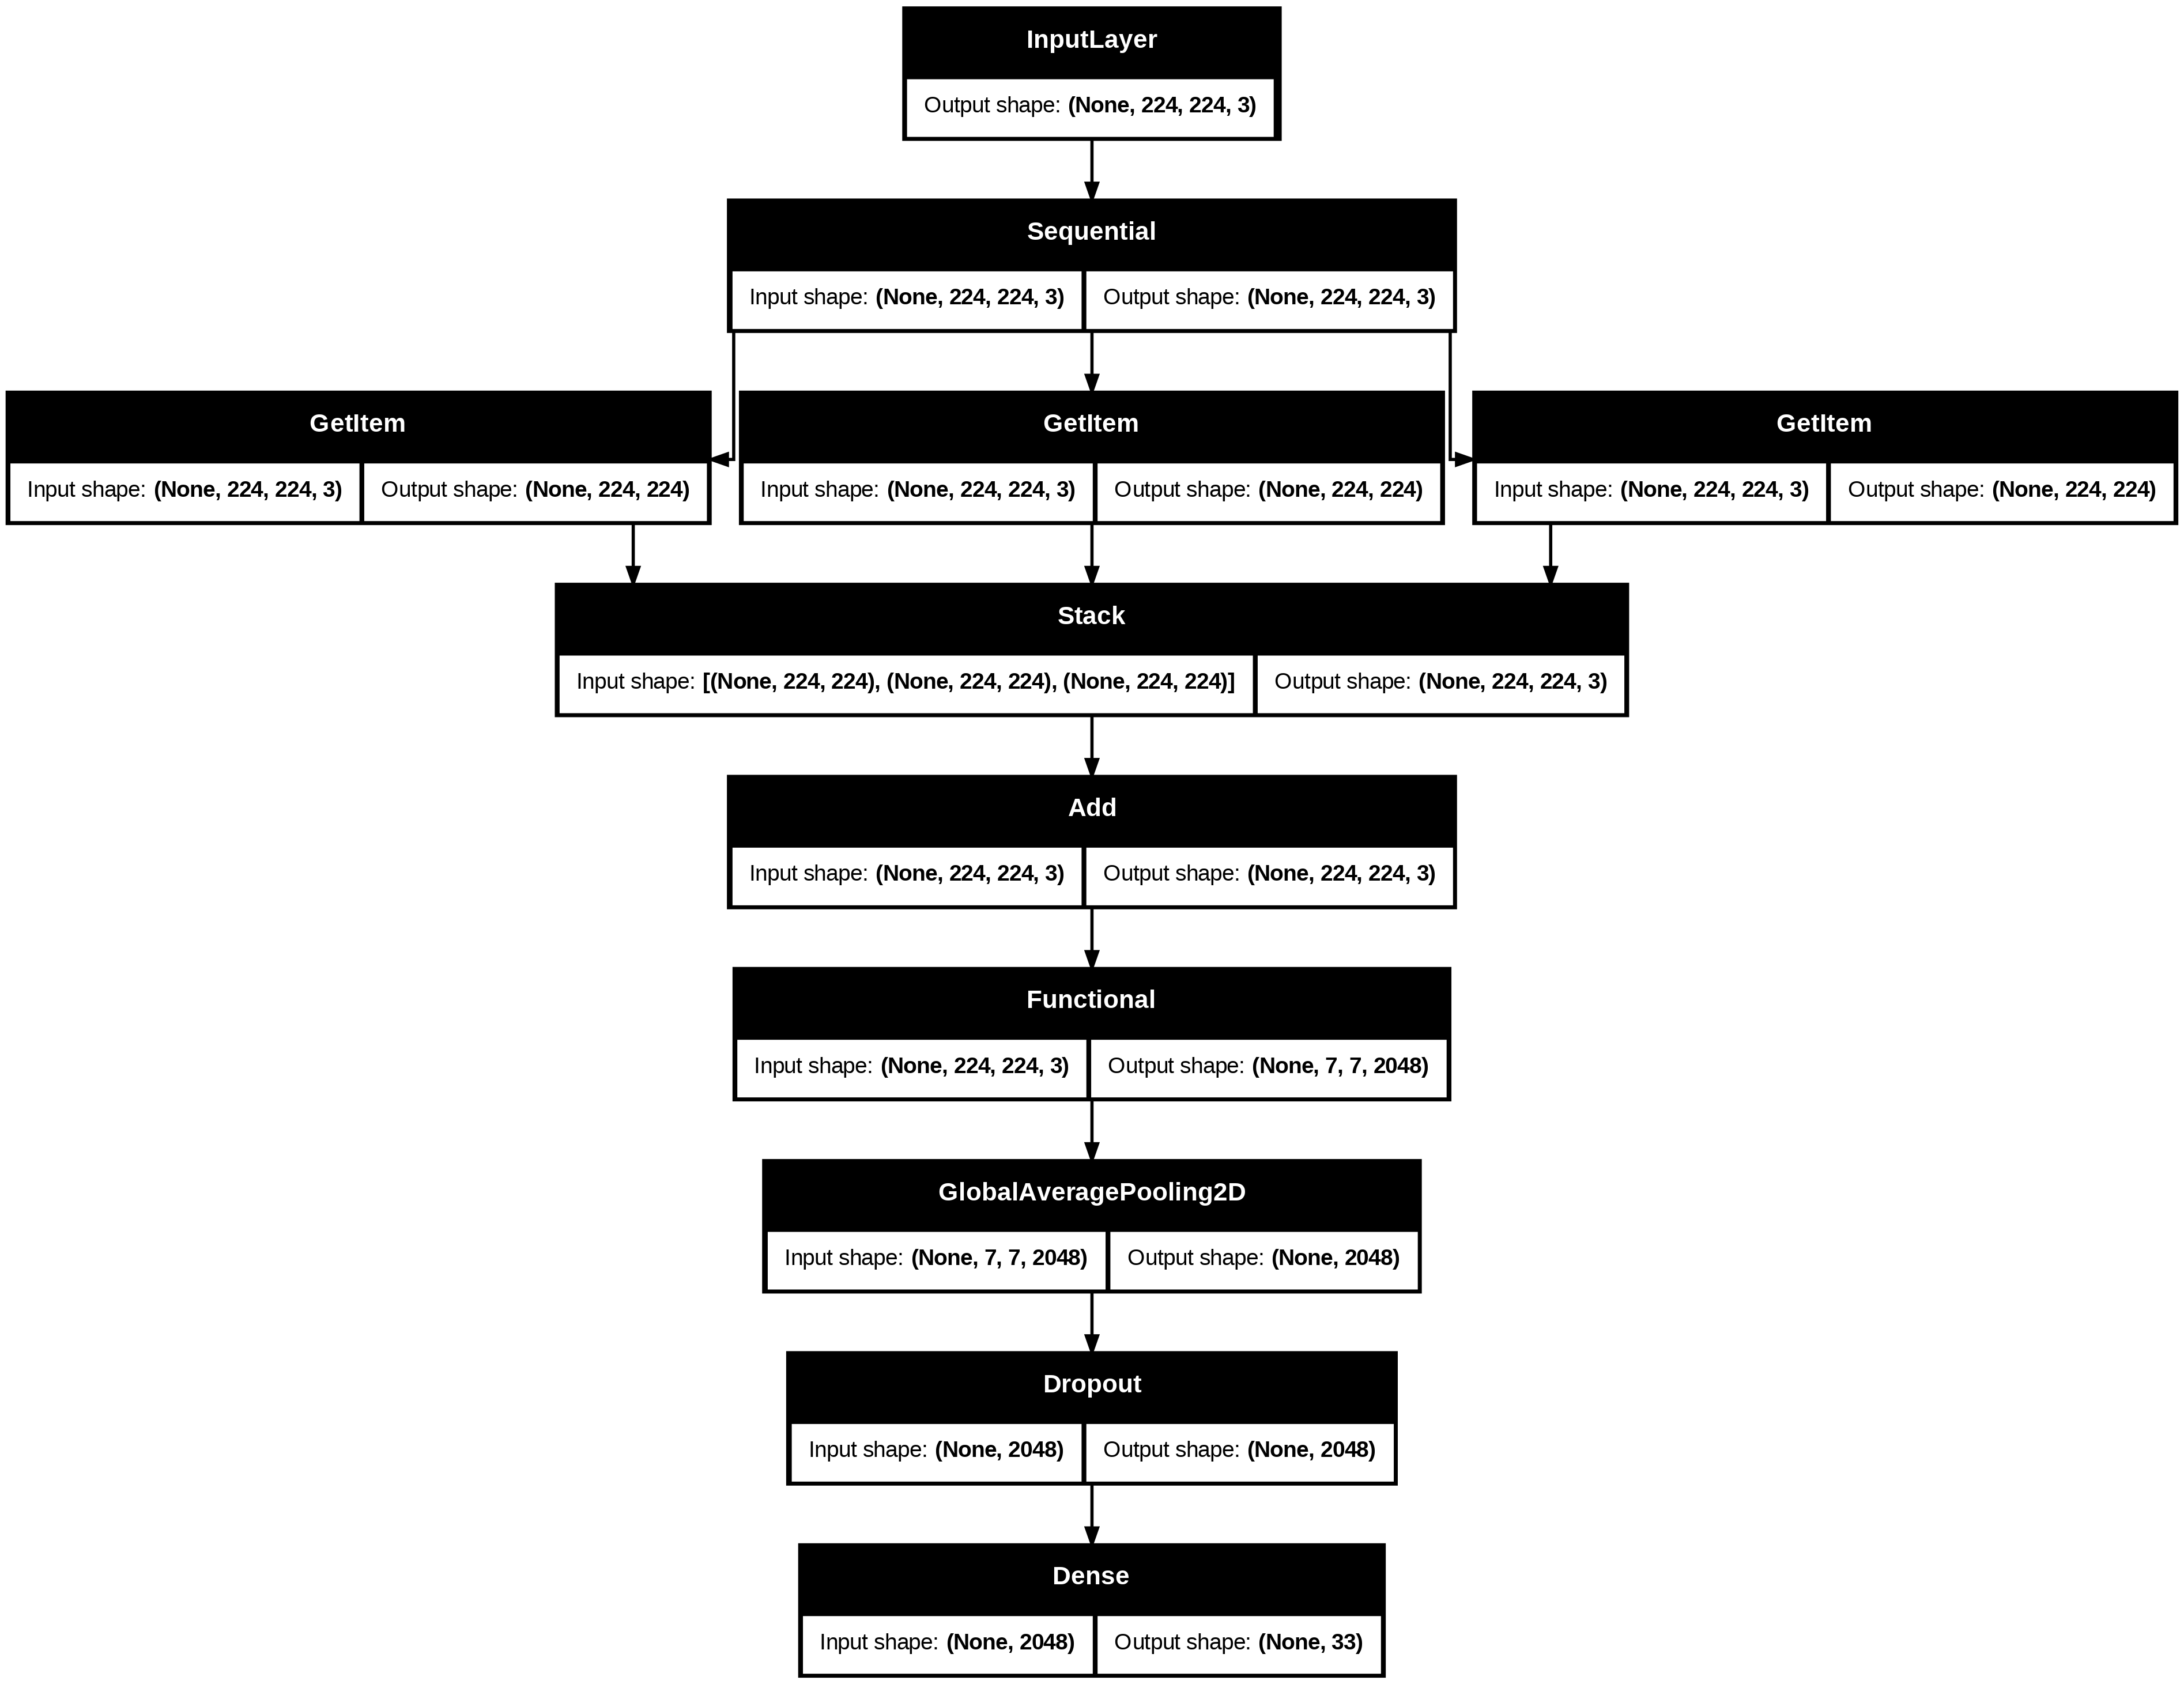

In [26]:
tf.keras.utils.plot_model(model, to_file='/content/model.png', show_shapes=True)
from IPython.display import Image
Image('/content/model.png')

### 4.1.6 Training

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])


In [28]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.0446 - loss: 4.2485


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.26
initial accuracy: 0.04


In [30]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.0570 - loss: 4.0787 - val_accuracy: 0.2017 - val_loss: 2.9374
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1756 - loss: 2.9401 - val_accuracy: 0.4244 - val_loss: 2.0846
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3884 - loss: 2.2452 - val_accuracy: 0.6261 - val_loss: 1.5669
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5392 - loss: 1.7787 - val_accuracy: 0.7227 - val_loss: 1.2233
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6219 - loss: 1.4930 - val_accuracy: 0.7983 - val_loss: 0.9519
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6783 - loss: 1.3043 - val_accuracy: 0.8361 - val_loss: 0.8559
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7273 - loss: 1.0928 - val_accuracy: 0.8739 - val_loss: 0.6804
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7653 - loss: 0.9794 - val_accuracy: 0.8866 - va

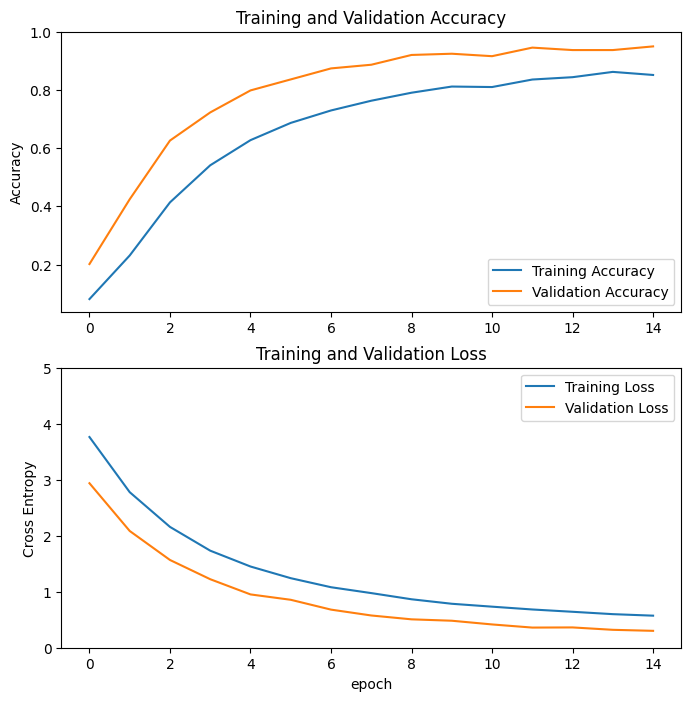

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### 4.1.7 Fine Tuning

In [32]:
base_model.trainable = True

In [33]:
print("Number of layers in the base model: ", len(base_model.layers))

# Update basing on the model in use and its structure
fine_tune_at = 143

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [35]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 33)             │         67,617 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,655,329 (90.24 MB)

 Trainable params: 15,043,617 (57.39 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [36]:
len(model.trainable_variables)

42

In [37]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 16/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8157 - loss: 0.6807 - val_accuracy: 0.9538 - val_loss: 0.2450
Epoch 17/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8755 - loss: 0.5065 - val_accuracy: 0.9748 - val_loss: 0.1679
Epoch 18/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8935 - loss: 0.4278 - val_accuracy: 0.9874 - val_loss: 0.1535
Epoch 19/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9132 - loss: 0.3667 - val_accuracy: 0.9874 - val_loss: 0.1224
Epoch 20/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9208 - loss: 0.3106 - val_accuracy: 0.9874 - val_loss: 0.1048
Epoch 21/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9416 - loss: 0.2653 - val_accuracy: 0.9874 - val_loss: 0.0787
Epoch 22/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9513 - loss: 0.2396 - val_accuracy: 0.9832 - val_loss: 0.0852
Epoch 23/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9448 - loss: 0.2198 - val_accuracy: 0

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

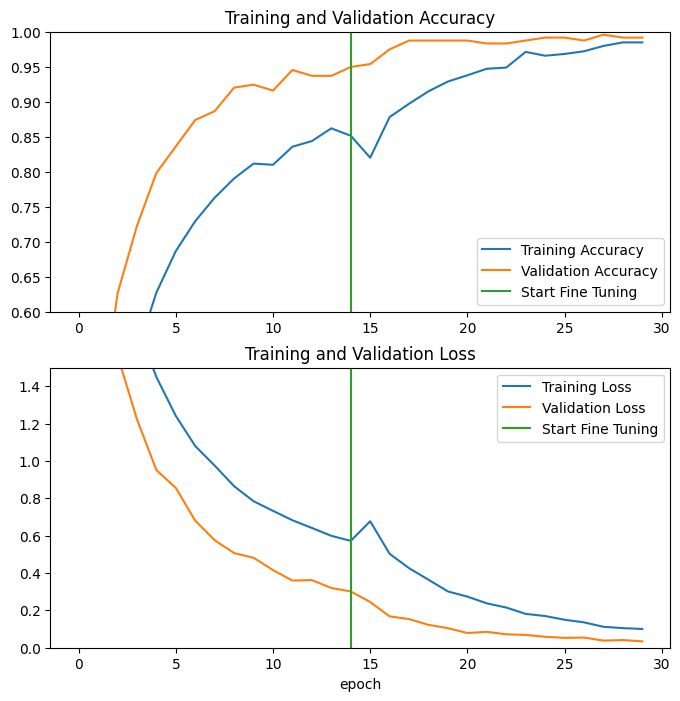

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 4.1.8 Model evaluation and prediction

In [42]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0228
Test accuracy : 1.0


Predictions:
 [15 29 10 12 12  0 23  2 20 11  8  2 20  2 32  9 31 25  7 13 18  8 13  3
 24  3 10 12  7 28 18  1]
Labels:
 [15 29 10 12 12  0 23  2 20 11  8  2 20  2 32  9 31 25  7 13 18  8 13  3
 24  3 10 12  7 28 18  1]


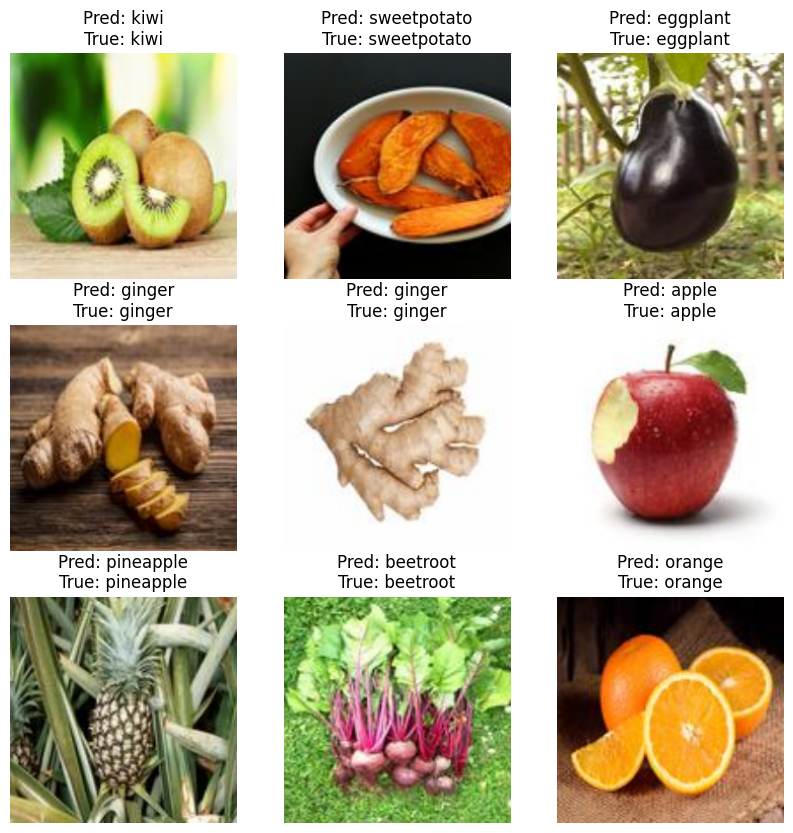

In [43]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)  # Shape: (batch_size, num_classes)

predicted_classes = np.argmax(predictions, axis=-1)  # Shape: (batch_size,)


print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(min(9, len(image_batch))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[label_batch[i]]}")
    plt.axis("off")

plt.show()


### 4.1.9 Save the model

In [46]:
model.save(os.path.join(MODEL_LOCATION, 'resnet_model.keras'))

## 5.2 Xception

Documentation:  
https://keras.io/api/applications/xception/




In [47]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

### 5.1.1 Data preprocessing

In [8]:
train_dir = DIR_TRAIN
validation_dir = DIR_VALIDATION

BATCH_SIZE = 32
IMG_SIZE = (299, 299)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 2362 files belonging to 33 classes.
Found 302 files belonging to 33 classes.


In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Number of validation batches: 8
Number of test batches: 2


In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


In [11]:
preprocess_input = tf.keras.applications.xception.preprocess_input

### 5.1.2 Base model

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 2048)


### 5.1.3 Feature extraction

When unfreezing a model that contains BatchNormalization layers in order to do fine-tuning, the BatchNormalization layers should be kept in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

### 5.1.4 Top layer: classifier

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [27]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 33)


In [28]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [29]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 33)                  │          67,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,929,097 (79.84 MB)

 Trainable params: 67,617 (264.13 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

### 5.1.5 Model and parameter summary

In [30]:
len(model.trainable_variables)

2

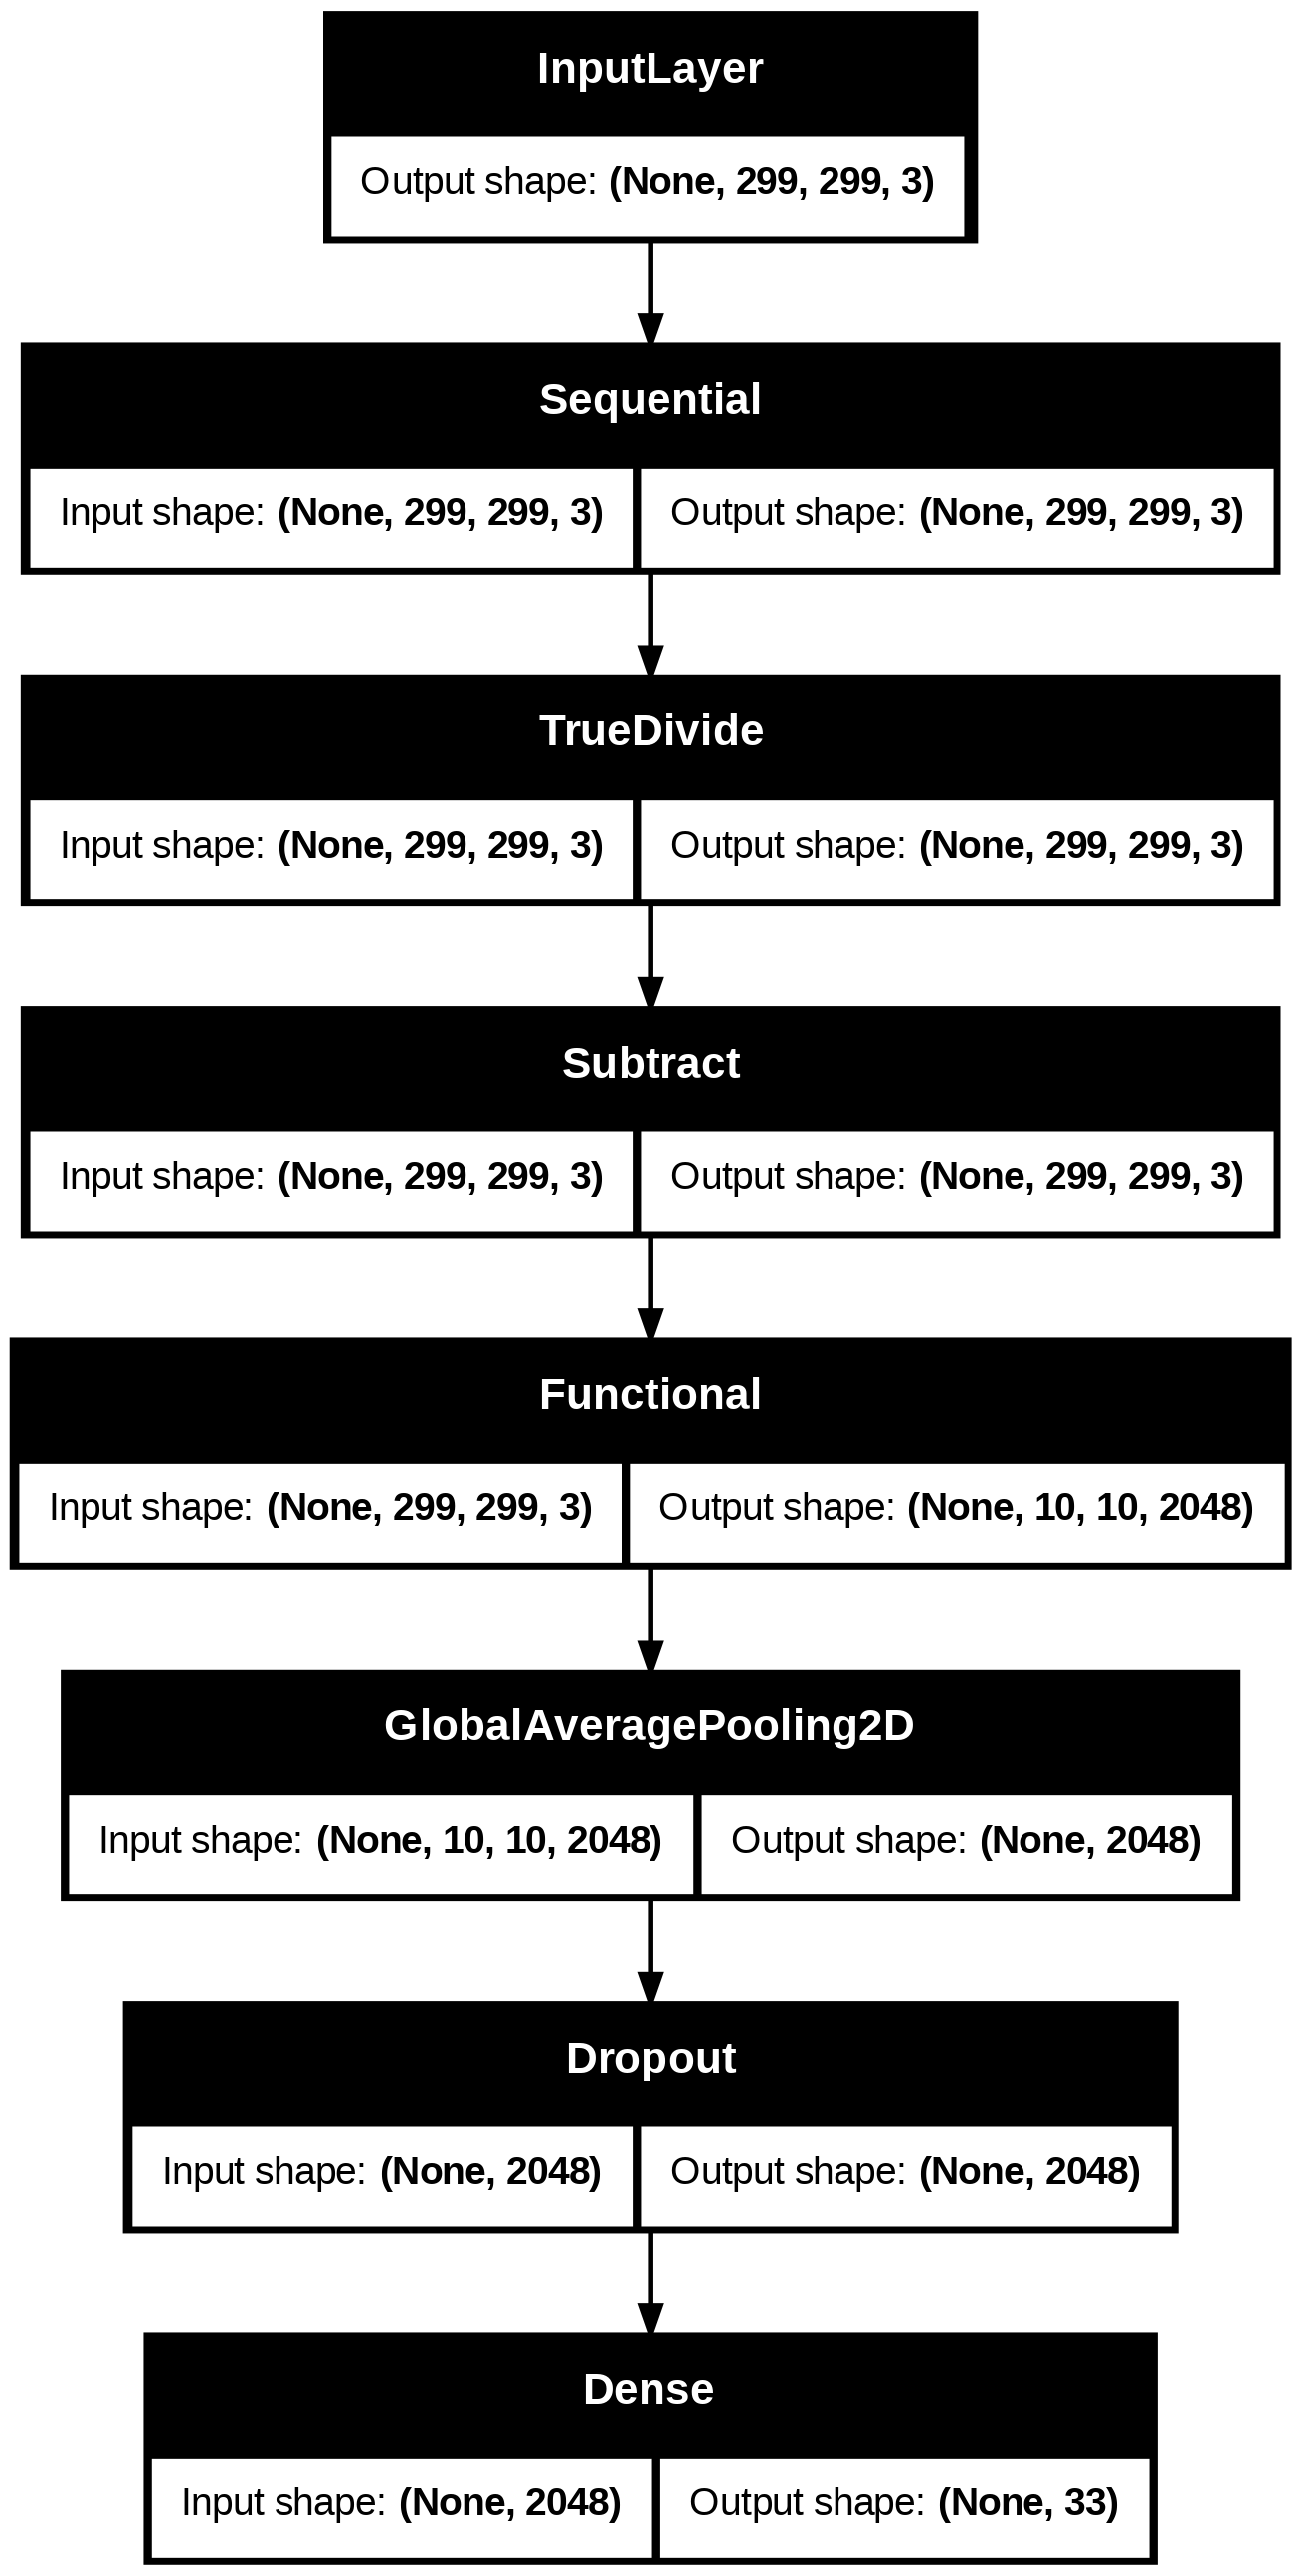

In [32]:
tf.keras.utils.plot_model(model, to_file='/content/model_xception.png', show_shapes=True)
from IPython.display import Image
Image('/content/model_xception.png')

### 5.1.6 Training

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])


In [36]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0102 - loss: 3.5299


In [37]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.55
initial accuracy: 0.02


In [38]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 66s 826ms/step - accuracy: 0.0652 - loss: 3.4584 - val_accuracy: 0.2311 - val_loss: 3.1574
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.2936 - loss: 3.0802 - val_accuracy: 0.4412 - val_loss: 2.8250
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.4586 - loss: 2.7659 - val_accuracy: 0.5630 - val_loss: 2.5309
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5657 - loss: 2.5036 - val_accuracy: 0.6807 - val_loss: 2.2357
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6235 - loss: 2.2526 - val_accuracy: 0.7437 - val_loss: 2.0098
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6715 - loss: 2.0722 - val_accuracy: 0.7815 - val_loss: 1.8183
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7258 - loss: 1.8860 - val_accuracy: 0.7941 - val_loss: 1.6539
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7334 - loss: 1.7304 - val_accuracy: 0.8151 -

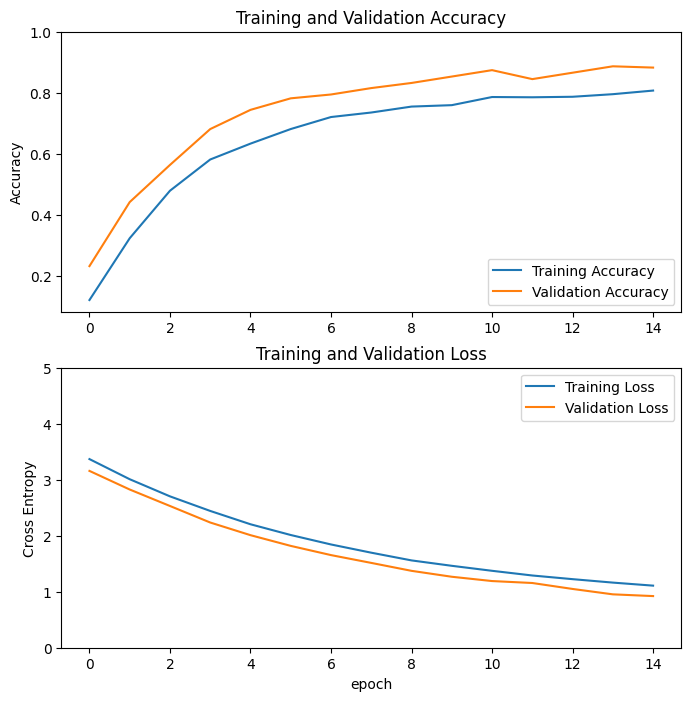

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### 5.1.7 Fine Tuning

In [40]:
base_model.trainable = True

In [42]:
print("Number of layers in the base model: ", len(base_model.layers))

# Update basing on the model in use and its structure
fine_tune_at = 107  # Beginning of the exit flow

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  132


In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [44]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 33)                  │          67,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,929,097 (79.84 MB)

 Trainable params: 8,469,977 (32.31 MB)

 Non-trainable params: 12,459,120 (47.53 MB)

In [45]:
len(model.trainable_variables)

33

In [47]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 16/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.7639 - loss: 1.1805 - val_accuracy: 0.9034 - val_loss: 0.7573
Epoch 17/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.7911 - loss: 0.9858 - val_accuracy: 0.8866 - val_loss: 0.6535
Epoch 18/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.7931 - loss: 0.8917 - val_accuracy: 0.8950 - val_loss: 0.5972
Epoch 19/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8211 - loss: 0.8092 - val_accuracy: 0.9328 - val_loss: 0.5142
Epoch 20/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8278 - loss: 0.7489 - val_accuracy: 0.9160 - val_loss: 0.4973
Epoch 21/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8431 - loss: 0.7042 - val_accuracy: 0.9454 - val_loss: 0.3984
Epoch 22/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8530 - loss: 0.6337 - val_accuracy: 0.9370 - val_loss: 0.3759
Epoch 23/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.8724 - loss: 0.5893 - val_accuracy: 

In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

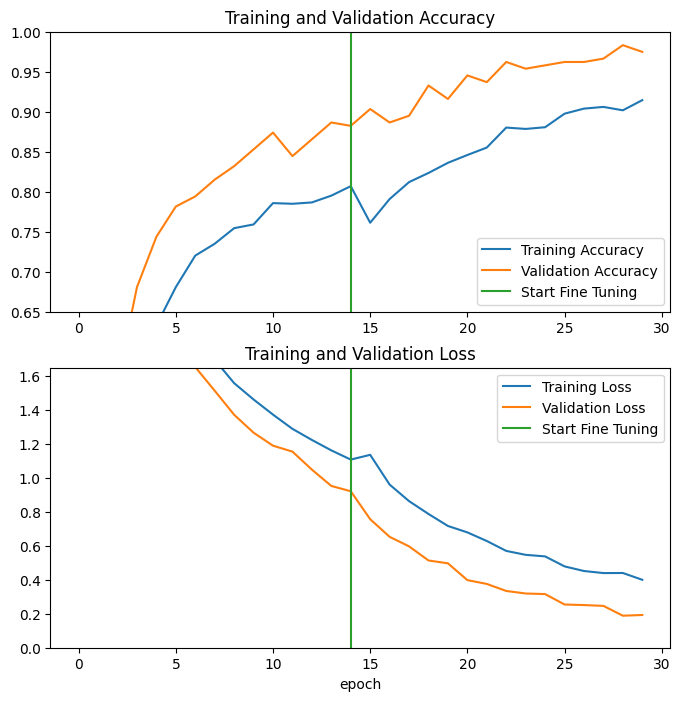

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.65, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.65])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 5.1.8 Model evaluation and prediction

In [53]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9583 - loss: 0.2061 
Test accuracy : 0.96875


Predictions:
 [27 26  7 14 23 28  9 26  2  8 28  7  8 29 27 13 21 29  5 12 30 18 25  5
 24 20 21 16 15 30 25 31]
Labels:
 [27 26  7  7 23 28 14 26  2  8 28  7  8 29 27 13 21 29  5 12 30 18 18  5
 24 20 21 16 15 30 25 31]


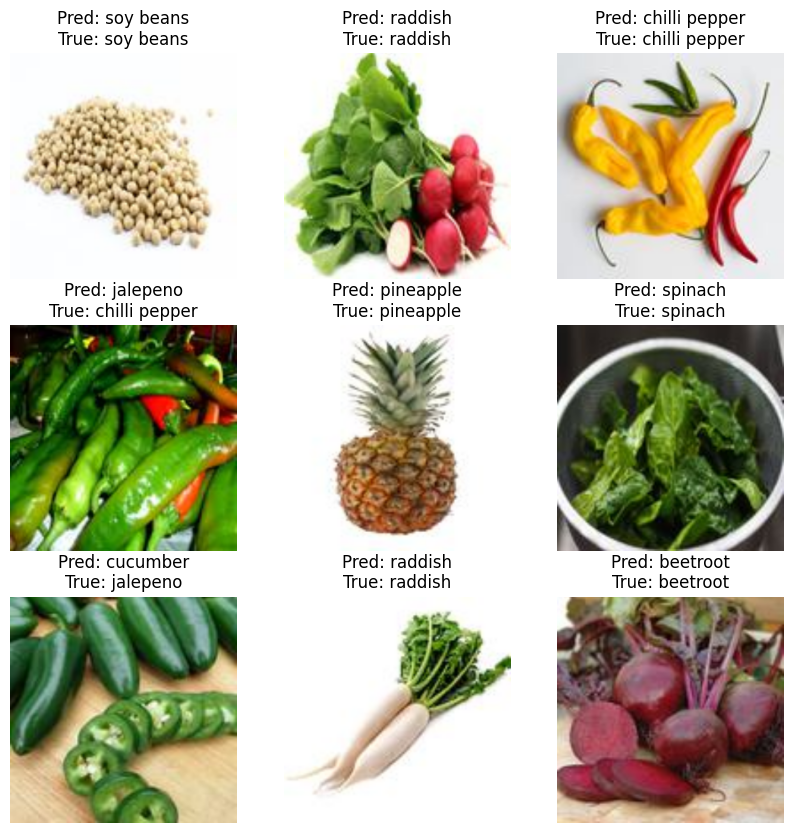

In [54]:

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)  # Shape: (batch_size, num_classes)

predicted_classes = np.argmax(predictions, axis=-1)  # Shape: (batch_size,)


print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(min(9, len(image_batch))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[label_batch[i]]}")
    plt.axis("off")

plt.show()


### 5.1.9 Save the model

In [56]:
model.save(os.path.join(MODEL_LOCATION, 'xception_model.keras'))